In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df_filtered= df[['engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]]

In [5]:
df_filtered.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

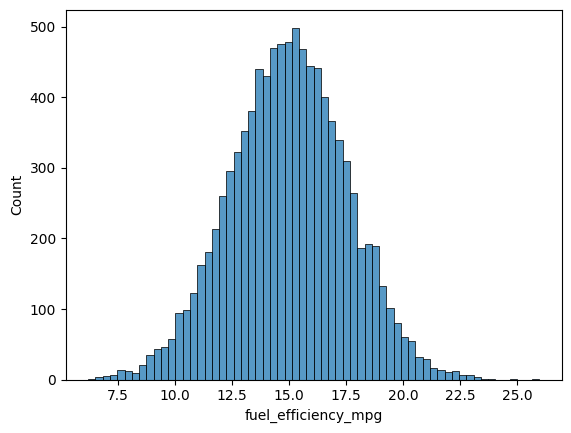

In [6]:
import seaborn as sns
%matplotlib inline
sns.histplot(df_filtered['fuel_efficiency_mpg'])

In [7]:
df_filtered.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [8]:
df_filtered['horsepower'].median()

np.float64(149.0)

In [9]:
n= len(df_filtered)
n_val= int(len(df_filtered)*0.2)
n_test = int(len(df_filtered)*0.2)
n_train= n-n_val-n_test


Shuffle data

In [10]:
import numpy as np
idx=np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df_filtered.iloc[idx[:n_train]]
df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
df_test = df_filtered.iloc[idx[n_train+n_val:]]

In [11]:
df_train = df_train.reset_index(drop=True)

In [12]:
#np.log1p(df_train.fuel_efficiency_mpg.values)

In [13]:
y_train=df_train.fuel_efficiency_mpg.values
y_val=df_val.fuel_efficiency_mpg.values
y_test =df_test.fuel_efficiency_mpg.values

In [14]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

Linear regression

In [15]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X= np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [16]:
train_linear_regression(df_train.values, y_train)

(np.float64(nan), array([nan, nan, nan, nan]))

In [17]:
df_train.isnull().sum()

engine_displacement      0
horsepower             429
vehicle_weight           0
model_year               0
dtype: int64

RMSE

In [18]:
def rmse(y, y_pred):
    error = y-y_pred
    se= error**2
    mse= se.mean()
    return np.sqrt(mse)

Fill na with 0

In [19]:
df_train_0= df_train.fillna(0)
w0, w= train_linear_regression(df_train_0.values, y_train)

In [20]:
y_pred = w0 + df_train_0.dot(w)

<Axes: ylabel='Count'>

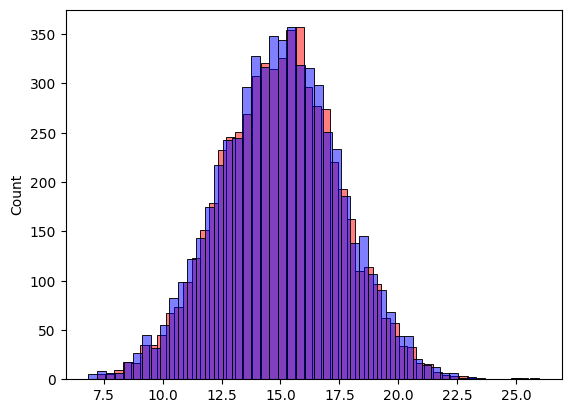

In [21]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [22]:
rmse(y_train, y_pred)

np.float64(0.5202614265099076)

Validation

In [23]:
df_val_0= df_val.fillna(0)
y_pred_v= w0+df_val_0.dot(w)
round(rmse(y_val, y_pred_v),2)

np.float64(0.52)

Fill na with mean of horsepower

In [24]:
df_train_mean= df_train.fillna(df_train['horsepower'].mean())
w0, w = train_linear_regression(df_train_mean.values, y_train)
y_pred_mean = w0 + df_train_0.dot(w)


<Axes: ylabel='Count'>

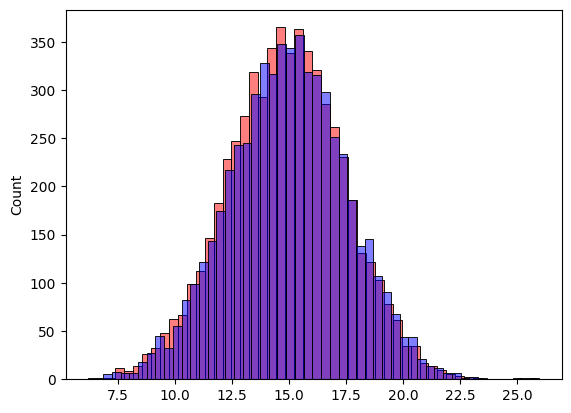

In [25]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [26]:
rmse(y_train, y_pred_mean)

np.float64(0.6248117960544057)

In [27]:
df_val_mean= df_val.fillna(df_train['horsepower'].mean())
y_pred_mean= w0+df_val_mean.dot(w)
round(rmse(y_val, y_pred_mean),2)

np.float64(0.46)

Regularization

In [28]:
def train_linear_regression_reg(X,y, r =0.001):
    ones = np.ones(X.shape[0])
    X= np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])


    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]
    

In [29]:
r_list = [0.0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_list:
    df_train_0= df_train.fillna(0)
    w0, w= train_linear_regression_reg(df_train_0.values, y_train, r)
    y_pred = w0 + df_train_0.dot(w)

    df_val_0= df_val.fillna(0)
    y_pred_v= w0+df_val_0.dot(w)
    rmse_value= round(rmse(y_val, y_pred_v),3)
    print(r, w0, rmse_value)

0.0 28.827365475106156 0.517
0.01 24.92683842008767 0.517
0.1 11.239661084961272 0.519
1 1.7315979411936366 0.522
5 0.3638075020692219 0.523
10 0.18306246622306527 0.523
100 0.018418017306977234 0.523


In [30]:
df_full_train = pd.concat([df_train, df_val])
df_full_train= df_full_train.reset_index(drop= True)
X_full_train = df_full_train.fillna(0)

In [31]:
y_full_train = np.concatenate([y_train, y_val])

In [33]:
w0, w= train_linear_regression_reg(X_full_train.values, y_full_train, r=0.01)

In [35]:
X_test= df_test.fillna(0)
y_pred= w0+X_test.dot(w)
rmse_value= round(rmse(y_test, y_pred),3)
print(w0, rmse_value)

24.645272806104025 0.517


In [47]:
def train_model(seed, df_filtered):
    print(seed)
    n= len(df_filtered)
    n_val= int(len(df_filtered)*0.2)
    n_test = int(len(df_filtered)*0.2)
    n_train= n-n_val-n_test
       
    idx=np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df_filtered.iloc[idx[:n_train]]
    df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
    df_test = df_filtered.iloc[idx[n_train+n_val:]]
    
    y_train=df_train.fuel_efficiency_mpg.values
    y_val=df_val.fuel_efficiency_mpg.values
    y_test =df_test.fuel_efficiency_mpg.values
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    df_train_0= df_train.fillna(0)
    w0, w= train_linear_regression(df_train_0.values, y_train)
    y_pred = w0 + df_train_0.dot(w)
    print("Score train: ",rmse(y_train, y_pred))

    df_val_0= df_val.fillna(0)
    y_pred_v= w0+df_val_0.dot(w)
    rmse_value= round(rmse(y_val, y_pred_v),3)
    print("score validation: ", rmse_value)
    return rmse_value



In [48]:
seed_list= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
score_list = []
for seed in seed_list:
    score = train_model(seed, df_filtered)
    score_list.append(score)

print(score_list)

0
Score train:  0.5171560913636251
score validation:  0.521
1
Score train:  0.5148529296311273
score validation:  0.521
2
Score train:  0.520558311480986
score validation:  0.523
3
Score train:  0.5198664820191077
score validation:  0.516
4
Score train:  0.5171675510792179
score validation:  0.511
5
Score train:  0.5195177528194667
score validation:  0.528
6
Score train:  0.5124114964022372
score validation:  0.531
7
Score train:  0.524763629954572
score validation:  0.509
8
Score train:  0.524306385184493
score validation:  0.515
9
Score train:  0.5219709782195826
score validation:  0.513
[np.float64(0.521), np.float64(0.521), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.528), np.float64(0.531), np.float64(0.509), np.float64(0.515), np.float64(0.513)]


In [49]:
round(np.std(score_list),3)

np.float64(0.007)

In [50]:
def train_model(seed):
    print(seed)
    n= len(df_filtered)
    n_val= int(len(df_filtered)*0.2)
    n_test = int(len(df_filtered)*0.2)
    n_train= n-n_val-n_test
       
    idx=np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df_filtered.iloc[idx[:n_train]]
    df_val = df_filtered.iloc[idx[n_train:n_train+n_val]]
    df_test = df_filtered.iloc[idx[n_train+n_val:]]
    
    y_train=df_train.fuel_efficiency_mpg.values
    y_val=df_val.fuel_efficiency_mpg.values
    y_test =df_test.fuel_efficiency_mpg.values
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    
    
    df_train_0= df_train.fillna(0)
    w0, w= train_linear_regression(df_train_0.values, y_train)
    y_pred = w0 + df_train_0.dot(w)
    print("Score train: ",rmse(y_train, y_pred))

    df_val_0= df_val.fillna(0)
    y_pred_v= w0+df_val_0.dot(w)
    rmse_value= round(rmse(y_val, y_pred_v),3)
    print("score validation: ", rmse_value)

    df_full_train = pd.concat([df_train, df_val])
    df_full_train= df_full_train.reset_index(drop= True)
    X_full_train = df_full_train.fillna(0)
    y_full_train = np.concatenate([y_train, y_val])
    w0, w= train_linear_regression_reg(X_full_train.values, y_full_train, r=0.001)
    X_test= df_test.fillna(0)
    y_pred= w0+X_test.dot(w)
    rmse_value= round(rmse(y_test, y_pred),3)
    print("score test: ", rmse_value)
    return rmse_value

train_model(seed=9)

9
Score train:  0.5219709782195826
score validation:  0.513
score test:  0.516


np.float64(0.516)